In [1]:
# Sample code for MPS of spin models
# 2017 Augst Tsuyoshi Okubo
# 2018 Feb. Bug fixed 
# 2019 Jan. Modified output
# 2020 Jan. Modified output
# 2020 Oct. Modified by TO
# 2020 Dec. Add appendix

In this code, we perform a matrix product (a tensor train) decomposition for a wave function. 
The input parameters are
* $N$ : number of spins 
* $m$ : spin size $m=2S +1$ (Total vector dimension is $m^N$.)
* chi_max : maximum bond dimension of MPS
* Jz : $J_z$ in the following Hamiltonian
* Jxy : $J_{xy}$ in the following Hamiltonian
* hx : $h_x$ in the following Hamiltonian

We consider spin model defined on the open boundary 1d chain those Hamiltonian is given by
$$ \mathcal{H} = \sum_{i=1}^{N-1} J_z S_i^z S_{i+1}^z + \sum_{i=1}^{N-1} J_{xy} (S_i^x S_{i+1}^x + S_i^yS_{i+1}^y)) - h_x \sum_{i=1}^N S_i^x$$.


This Hamiltonian can represent several situations. For example, when we set parameters,
* $J_z = -1$, $J_{xy} = 0$, $h_x \neq 0$, and $m = 2$ 

It represents the transverse field Ising chain (with the open boundary condition).
If you set
* $J_z = J_{xy} = 1$, $h_x = 0$ 

It represents the $S=(m-1)/2$ Heisenberg model (with the open boundary condition).

After setting the Hamiltoniam parameters, first, we calculate the lowest eigenvalue and eigenvector (the ground state) of $\mathcal{H}$. From the eigenvector, we construct the exact matrix product state (tensor train decomposition). Then we truncate the each bond dimension to "chi_max" and make an approximated vector.
Finally, the code calculate the distance between the exact vector and the approximated vector. 

In the appedix, we calculate chi_max dependece of the distance.

In [2]:
import numpy as np
import scipy.linalg as linalg
import ED
import MPS
import argparse
import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
## input parameters
N = 16 ## system size N
m = 2  ## Spin size m=2S +1 (total vector dimension is m^N)
Jz = -1.0 ## SzSz interaction
Jxy = 0.0 ## SxSx and SySy interactions
hx = 0.4 ## extarnal transverse magnetic field
chi_max = 2 ## maximum bond dimension at truncation

In [4]:
## Main calculation

print("Model parameters: Jz, Jxy, hx = "+repr(Jz)+", "+repr(Jxy)+", "+repr(hx))
print("Parameters: N, m, chi_max = "+repr(N)+", "+repr(m)+ ", "+repr(chi_max))

D=0.0
eig_val,eig_vec = ED.Calc_GS(m,Jz,Jxy,hx,D,N,k=1)


print("Ground state energy per bond = "+repr(eig_val[0]/(N-1)))


Model parameters: Jz, Jxy, hx = -1.0, 0.0, 0.4
Parameters: N, m, chi_max = 16, 2, 2
Ground state energy per bond = -0.3008312739132688


In [5]:
## Make exact MPS (from "left")
Tn = []
lam = [np.ones((1,))]
lam_inv = 1.0/lam[0]
R_mat = eig_vec[:,0].reshape(m,m**(N-1))

chi_l=1
for i in range(N-1):
    U,s,VT = linalg.svd(R_mat,full_matrices=False)
    chi_r = s.size

    Tn.append(np.tensordot(np.diag(lam_inv),U.reshape(chi_l,m,chi_r),(1,0)).transpose(1,0,2))
    lam.append(s)
    lam_inv = 1.0/s
    R_mat = np.dot(np.diag(s),VT).reshape(chi_r*m,m**(N-i-2))
    chi_l = chi_r
Tn.append(VT.reshape(m,m,1).transpose(1,0,2))
lam.append(np.ones((1,)))


In [6]:
## Calculate Energy
Env_left=[]
Env_right=[]
for i in range(N):
    Env_left.append(np.identity((lam[i].shape[0])))
    Env_right.append(np.dot(np.dot(np.diag(lam[i+1]),np.identity((lam[i+1].shape[0]))),np.diag(lam[i+1])))

Tn_ex = copy.deepcopy(Tn)
lam_ex = copy.deepcopy(lam)
E_exact = MPS.Calc_Energy(Env_left,Env_right,Tn_ex,lam_ex,Jz,Jxy,hx,D)
print("Energy of Exact MPS = "+repr(E_exact))


Energy of Exact MPS = -0.30083127391326925


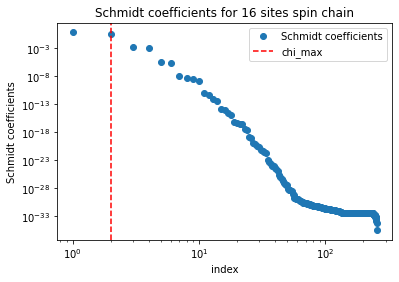

In [7]:
## plot Schmidt coefficient at N/2
## Red line indicates the position of chi_max

plt.title("Schmidt coefficients for "+repr(N)+" sites spin chain")
plt.plot(np.arange(len(lam_ex[N//2]))+1,lam_ex[N//2]**2,"o",label="Schmidt coefficients")
plt.axvline([chi_max],0,1,  c="red", linestyle='dashed', label="chi_max") ## position of chi_max
plt.xlabel("index")
plt.xscale("log")
plt.ylabel("Schmidt coefficients")
plt.yscale("log")
plt.legend()
plt.show()




In [8]:
## Truncation 
#Tn_ex=Tn
#lam_ex=lam
for i in range(N-1):
    chi = min(chi_max,lam[i+1].shape[0])
    lam[i+1]=lam[i+1][:chi]
    Tn[i]=Tn[i][:,:,:chi]
    Tn[i+1]=Tn[i+1][:,:chi,:]

In [9]:
## Calculate Energy for truncated MPS
Env_left=[]
Env_right=[]
for i in range(N):
    Env_left.append(np.identity((lam[i].shape[0])))
    Env_right.append(np.dot(np.dot(np.diag(lam[i+1]),np.identity((lam[i+1].shape[0]))),np.diag(lam[i+1])))

print("Truncation: chi_max = "+repr(chi_max))
E_truncated = MPS.Calc_Energy(Env_left,Env_right,Tn,lam,Jz,Jxy,hx,D)
print("Energy of MPS with truncation = "+repr(E_truncated))
print("Energy difference: E_truncated - E_exact =" + repr(E_truncated - E_exact))

Truncation: chi_max = 2
Energy of MPS with truncation = -0.2995131255929267
Energy difference: E_truncated - E_exact =0.0013181483203425493


In [10]:
## Distance between Exact MPS and truncated MPS

vec_ex = MPS.remake_vec(Tn_ex,lam_ex)
vec_ap = MPS.remake_vec(Tn,lam)
print("Distance between exact and truncated MPS = "+repr(linalg.norm(vec_ex - vec_ap)))


Distance between exact and truncated MPS = 0.14242015267789654


## Appendix: bond dimension dependence 

In this appendix, we calculate the distance between the original and approximated vector as a function of chi_max. 
We also calculate approximated energy as a function of chi_max.

We use the same original vector as the main part.   
You can set maxmum and minimum value of chi_max for the calculation.


In [11]:
min_chi_max = 1
max_chi_max = 20 ## maximum bond dimension of the exact MPS is m**(N/2)
d_chi_max = 1

In [12]:
chi_max_list = np.arange(min_chi_max, max_chi_max+1, d_chi_max, dtype=int)
chi_list = np.ones((N+1,),dtype=int)
vec_ex = MPS.remake_vec(Tn_ex,lam_ex)

distances=[]
energies=[]
for chi_max in chi_max_list:
    for i in range(N-1):
        chi = min(chi_max,lam_ex[i+1].shape[0])
        chi_list[i+1] = chi
    lam = [np.ones((1,))]
    Tn = []
    for i in range(N):
        lam.append(lam_ex[i+1][:chi_list[i+1]])
        Tn.append(Tn_ex[i][:,:chi_list[i],:chi_list[i+1]])
    vec_ap = MPS.remake_vec(Tn,lam)
    distances.append(linalg.norm(vec_ex - vec_ap))
    
    ## Calculate Energy for truncated MPS
    Env_left=[]
    Env_right=[]
    for i in range(N):
        Env_left.append(np.identity((lam[i].shape[0])))
        Env_right.append(np.dot(np.dot(np.diag(lam[i+1]),np.identity((lam[i+1].shape[0]))),np.diag(lam[i+1])))
        
    energies.append(MPS.Calc_Energy(Env_left,Env_right,Tn,lam,Jz,Jxy,hx,D))

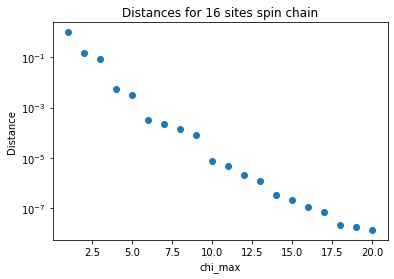

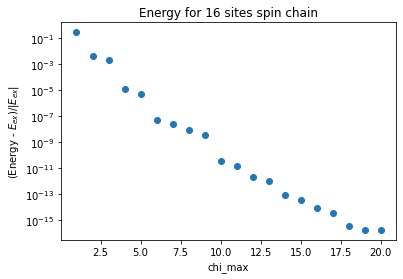

In [13]:
## plot distances

plt.title("Distances for "+repr(N)+" sites spin chain")
plt.plot(chi_max_list,distances,"o")
plt.xlabel("chi_max")
plt.ylabel("Distance")
plt.yscale("log")
plt.show()

plt.title("Energy for "+repr(N)+" sites spin chain")
plt.plot(chi_max_list,(energies-E_exact)/np.abs(E_exact),"o")
plt.xlabel("chi_max")
plt.ylabel("(Energy - $E_{ex}$)/$|E_{ex}|$")
plt.yscale("log")
plt.show()

